<a href="https://colab.research.google.com/github/nadya1462/NLP-Project/blob/main/decoding_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing the packages

In [47]:
import os, requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from statsmodels.miscmodels.ordinal_model import OrderedModel

import torch
from torch import nn
from torch import optim

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading the dataset

In [49]:
fname = "stringer_orientations.npy"
url = "https://osf.io/ny4ut/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

dat = np.load('stringer_orientations.npy', allow_pickle=True).item()

In [50]:
fname = "fitted_params.pkl"
url = "https://github.com/JKilgallen/Neurons/raw/main/fitted_params.pkl"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

with open('fitted_params.pkl', 'rb') as f:
  params = pkl.load(f)
params = params.set_index('neuron')

In [51]:
fname = "populations.pkl"
url = "https://github.com/JKilgallen/Neurons/raw/main/populations.pkl"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

with open('populations.pkl', 'rb') as f:
  populations = pkl.load(f)

In [60]:
high_div_pop_ind = populations['high_diversity']
high_sel_pop_ind = populations['high_selectivity']

### Linear Regression approach

In [61]:
def get_LG_scores(model, sresp, istim):
  """
  Calculate the score for fitting Linear Regression.

  Parameters
  -----------
  sresp : array_like (n_stimulus, n_features)
    The vector of features for each stimulus.
  istim : array_like
    The vector of stimulus.

  Returns
  -------
  score : float
    The score of the fit.
  """

  r2_score = model.score(sresp, istim) # the coefficient of determination of the prediction

  istim_pred = model.predict(sresp)
  mse = mean_squared_error(istim, istim_pred)

  return r2_score, mse

In [64]:
#inds = high_div_pop_ind
inds = high_sel_pop_ind

sresp, istim = dat['sresp'][inds, :], dat['istim']

In [65]:
# spliting the data into train and test sets
sresp_train, sresp_test, istim_train, istim_test = train_test_split(sresp.T, istim,
                                                                    test_size = 0.3, random_state = 42)

reg = LinearRegression().fit(sresp_train, istim_train)

# train scores
train_r2_score, train_mse = get_LG_scores(reg, sresp_train, istim_train)
print(f"Train r2-score: {train_r2_score}")
print(f"Train mse: {train_mse}\n")


# test scores
test_r2_score, test_mse = get_LG_scores(reg, sresp_test, istim_test)
print(f"Test r2-score: {test_r2_score}")
print(f"Test mse: {test_mse}")

Train r2-score: 1.0
Train mse: 2.0958224736314523e-26

Test r2-score: -59.04941454041165
Test mse: 207.3980937779639


### Non-linear Regression approach

In [14]:
def get_LG_scores(model, sresp, istim):
  """
  Calculate the score for fitting Linear Regression.

  Parameters
  -----------
  sresp : array_like (n_stimulus, n_features)
    The vector of features for each stimulus.
  istim : array_like
    The vector of stimulus.

  Returns
  -------
  score : float
    The score of the fit.
  """

  r2_score = model.score(sresp, istim) # the coefficient of determination of the prediction

  istim_pred = model.predict(sresp)
  mse = mean_squared_error(istim, istim_pred)

  return r2_score, mse

In [15]:
num_neurons = 10000
num_stim = 4000

inds = fitted_params['neuron'][:num_neurons]

sresp, istim = dat['sresp'][inds, :num_stim], dat['istim'][:num_stim]

In [ ]:
polynomial_converter = PolynomialFeatures(degree = 2, include_bias = False)
poly_features = polynomial_converter.fit_transform(sresp.T)

# spliting the data into train and test sets
sresp_train, sresp_test, istim_train, istim_test = train_test_split(poly_features, istim,
                                                                    test_size = 0.3, random_state = 42)

reg = LinearRegression(fit_intercept=True).fit(sresp_train, istim_train)

# train scores
train_r2_score, train_mse = get_LG_scores(reg, sresp_train, istim_train)
print(f"Train r2-score: {train_r2_score}")
print(f"Train mse: {train_mse}\n")


# test scores
test_r2_score, test_mse = get_LG_scores(reg, sresp_test, istim_test)
print(f"Test r2-score: {test_r2_score}")
print(f"Test mse: {test_mse}")

### Ordinal and Multinomial Logistic Regression approach

In [9]:
num_neurons = 10000
num_stim = 4000

inds = fitted_params['neuron'][:num_neurons]

sresp, istim = dat['sresp'][inds, :num_stim], dat['istim'][:num_stim]

In [11]:
# spliting the data into train and test sets
sresp_train, sresp_test, istim_train, istim_test = train_test_split(sresp.T, istim,
                                                                    test_size = 0.3, random_state = 42)

In [ ]:
clf = LogisticRegression(random_state=0, solver = 'sag', multi_class = 'multinomial').fit(sresp_train, istim_train)

In [ ]:
mod_prob = OrderedModel(istim_train, sresp_train, distr='probit')

### Deep Learning approach

In [42]:
class DeepNetSigmoid(nn.Module):
  """ network with a single hidden layer h with a Sigmoid activation function """

  def __init__(self, n_inputs, n_hidden):
    super().__init__()  # needed to invoke the properties of the parent class nn.Module
    self.in_layer = nn.Linear(n_inputs, n_hidden) # neural activity --> hidden units
    self.out_layer = nn.Linear(n_hidden, 1) # hidden units --> output

  def forward(self, r):
    h = torch.sigmoid(self.in_layer(r))  # hidden representation # h is size (n_inputs, n_hidden)
    y = self.out_layer(h) # y is size (n_inputs, 1)

    return y

In [43]:
def train(net, loss_fn, train_data, train_labels,
          n_epochs=50, learning_rate=1e-4):
  """Run gradient descent to optimize parameters of a given network

  Args:
    net (nn.Module): PyTorch network whose parameters to optimize
    loss_fn: built-in PyTorch loss function to minimize
    train_data (torch.Tensor): n_train x n_neurons tensor with neural
      responses to train on
    train_labels (torch.Tensor): n_train x 1 tensor with orientations of the
      stimuli corresponding to each row of train_data
    n_epochs (int, optional): number of epochs of gradient descent to run
    learning_rate (float, optional): learning rate to use for gradient descent

  Returns:
    (list): training loss over iterations

  """

  # Initialize PyTorch SGD optimizer
  optimizer = optim.SGD(net.parameters(), lr=learning_rate)

  # Placeholder to save the loss at each iteration
  train_loss = []

  # Loop over epochs
  for i in range(n_epochs):

    # compute network output from inputs in train_data
    out = net(train_data)  # compute network output from inputs in train_data

    # evaluate loss function
    loss = loss_fn(out, train_labels)

    # Clear previous gradients
    optimizer.zero_grad()

    # Compute gradients
    loss.backward()

    # Update weights
    optimizer.step()

    # Store current value of loss
    train_loss.append(loss.item())  # .item() needed to transform the tensor output of loss_fn to a scalar

    # Track progress
    if (i + 1) % (n_epochs // 5) == 0:
      print(f'iteration {i + 1}/{n_epochs} | loss: {loss.item():.3f}')

  return train_loss

In [44]:
def plot_train_loss(train_loss):
  plt.plot(train_loss)
  plt.xlabel('iterations of gradient descent')
  plt.ylabel('mean squared error')
  plt.show()

In [45]:
num_neurons = 10000
num_stim = 4000

inds = fitted_params['neuron'][:num_neurons]

sresp, istim = dat['sresp'][inds, :num_stim], dat['istim'][:num_stim]

# spliting the data into train and test sets
sresp_train, sresp_test, istim_train, istim_test = train_test_split(torch.from_numpy(sresp.T), torch.from_numpy(istim),
                                                                    test_size = 0.3, random_state = 42)

iteration 10/50 | loss: 18.671
iteration 20/50 | loss: 9.996
iteration 30/50 | loss: 5.184
iteration 40/50 | loss: 3.789
iteration 50/50 | loss: 3.384


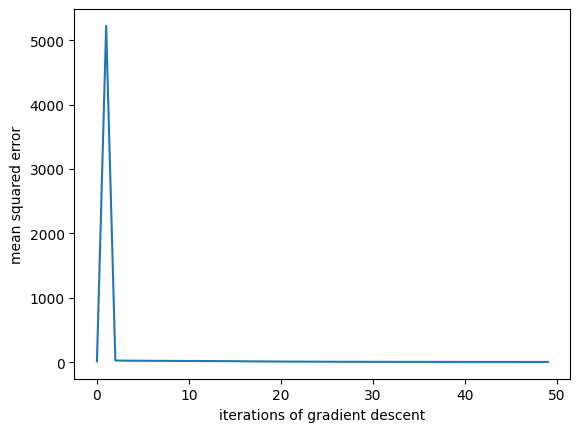

In [46]:
# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

# Initialize network with 10 hidden units
net = DeepNetSigmoid(num_neurons, 4096)

# Initialize PyTorch mean squared error loss function
loss_fn = nn.MSELoss()

# Run gradient descent on data
train_loss = train(net, loss_fn, sresp_train.type(torch.FloatTensor), istim_train.type(torch.FloatTensor),
                    n_epochs=50, learning_rate=1e-2)

# Plot the training loss over iterations of GD
plot_train_loss(train_loss)